In [1]:
import sys

print (sys.version)
import matplotlib.pyplot as plt
import warnings
import math
import random
import numpy as np
from scipy.linalg import sqrtm
from numpy.linalg import det
import numpy.linalg as LA

warnings.filterwarnings("ignore")

3.6.3 (default, Jul 10 2020, 11:37:39) 
[GCC 5.4.0 20160609]


In [2]:
def convert_initial_values_to_tensors(xa, xb, Ca, Cb):
    return torch.tensor(xa), torch.tensor(xb), torch.tensor(Ca), torch.tensor(Cb)

def read_in_initial_values(dimension, as_tensors=False):
    fin = open('init_cond/' + str(dimension) + ".txt", 'r')
    inp = fin.read().splitlines()
    fin.close()
    xa = []
    for val in inp[0].split(' ')[:-1]:
        xa.append(float(val))
    xa = np.array(xa)
    
    xb = []
    for val in inp[1].split(' ')[:-1]:
        xb.append(float(val))
    xb = np.array(xb)
    
    inp = inp[2:]
    Ca = []
    for i in range(dimension):
        row = []
        for val in inp[i].split(' ')[:-1]:
            row.append(float(val))
        Ca.append(row)    
    Ca = np.array(Ca)

    Cb = []
    for i in range(dimension):
        row = []
        for val in inp[i+dimension].split(' ')[:-1]:
            row.append(float(val))
        Cb.append(row)    
    Cb = np.array(Cb)
    if as_tensors:
        return convert_initial_values_to_tensors(xa, xb, Ca, Cb)
    else:
        return xa, xb, Ca, Cb

 


In [3]:
class Space():
    def __init__(self):
        self.ang_meas_sigma = 0
        self.dim = 0
        self.size_box = 0
        self.border = 0

    def get_figure(self):
        return plt.figure()
    
    def get_axes(self):
        if(self.dim >= 3):
            return plt.axes(projection='3d')
        else:
            return plt.axes()

    def get_3D_axes(self):
        return plt.axes(projection='3d')

In [4]:
def inv(mat):
    if mat.size > 1:
        return LA.inv(mat)
    else:
        return 1/mat

In [5]:
my_space = Space()
N_agents = 7
N_samples = 4500
N_max_gmms = 15
P_link = .02
axis_length = 100

N_time_steps = 1000

use_predefined_values=True
print_value=False
print_values=False

my_space.ang_meas_sigma = 5 * math.pi/180
my_space.dim = 2
my_space.size_box = axis_length * np.ones((my_space.dim,1))
my_space.border = 10

visualize = my_space.dim == 2

In [6]:
target_loc = (np.random.rand(my_space.dim, 1) * (my_space.size_box - 2*my_space.border) + my_space.border).reshape((my_space.dim, ))
print(target_loc)
KL_inputs = []
for val in target_loc:
    #For computation time 
    if(my_space.dim < 3):
        KL_inputs.append(np.linspace(val-5, val+5,num=30))
    else:
        KL_inputs.append(np.linspace(val-2, val+2,num=10))


KL_inputs = np.array(KL_inputs)

if my_space.dim == 1:
    x = np.mgrid[target_loc[0]-5:target_loc[0]+5:.1]
    pos = np.empty(x.shape + (2, ))
    pos[:, 0] = x

else:
    x, y = np.mgrid[target_loc[0]-5:target_loc[0]+5:.1, target_loc[1]-5:target_loc[1]+5:.1]
    pos = np.empty(x.shape + (2, ))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

[83.78970298 57.39763479]


In [7]:
def generateGraphHypercube(dims, N_sensors, dist_prob):

    #Constants
    dist_prob_scalar = 1.2

    #Initialize variables
    A = np.zeros((N_sensors, N_sensors))
    locs = np.zeros((dims, N_sensors))
    
    for i in range(N_sensors):
        side = random.randint(0, dims - 1)
        idx = [j for j in range(side)] + [k for k in range(side + 1, dims)]
        locs[side][i] = random.randint(0, 1)
        for val in idx:
            locs[val][i] = random.random()
            
    todo = np.arange(1, N_sensors)

    iter_num = 1
    while (not len(todo) == 0):
        for k in todo:
            if iter_num == 1:
                to_scan = [i for i in range(k)]
            else:
                to_scan = [i for i in range(N_sensors)]
            
            for s in to_scan:
                if not s==k:
                    link_dist = np.linalg.norm(locs[:, k] - locs[:, s])                    
                    prob_link = math.exp(-0.5*(link_dist/dist_prob)**2)
                    if random.random() < prob_link:
                        A[s][k] = 1
                        A[k][s] = 1
        
        todo = np.argwhere(np.sum(A, axis = 0) == 0).reshape(-1)
        iter_num += 1
        dist_prob *= dist_prob_scalar
    

    #Do not completely understand this part
    my_eigs, _ = np.linalg.eig(np.diag(np.sum(A, axis = 0)) - A)
    my_eigs = np.sort(my_eigs)
    while abs(my_eigs[1]) < 1e-8:
        row = random.randint(0, N_sensors - 1)
        col = random.randint(0, N_sensors - 1)
        A[row][col] = 1
        A[col][row] = 1
        my_eigs, _ = np.linalg.eig(np.diag(np.sum(A, axis = 0)) - A)
        my_eigs = np.sort(my_eigs)
    
    return A, locs

Diameter of the graph is: 4


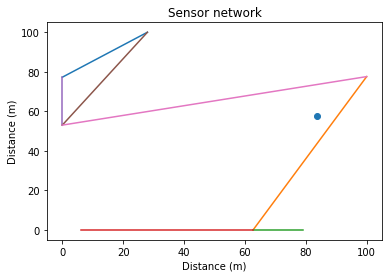

In [8]:
dist = 6
while(dist > 4):
    A, sens = generateGraphHypercube(my_space.dim, N_agents, 0.2)

    sens *= axis_length


    curr_A_pow = np.copy(A)
    sum_A = np.copy(A)
    dist = 1

    while np.count_nonzero(sum_A == 0) > 0:
        curr_A_pow = np.dot(curr_A_pow, A)
        sum_A += curr_A_pow
        dist += 1

print("Diameter of the graph is: " + str(dist))

D = np.sum(A, axis = 0)
max_deg = max(D)
neighbors = {}
for i in range(N_agents):
    neighbors[i] = np.nonzero(A[i])

if(visualize):
    fig = my_space.get_figure()
    ax= my_space.get_axes()

    for i in range(1, N_agents):
        for j in range(i):
            if A[i][j] == 1:
                if my_space.dim > 2:
                    X = [sens[0][i], sens[0][j]]
                    Y = [sens[1][i], sens[1][j]]
                    Z = [sens[2][i], sens[2][j]]
                    ax.plot(X, Y, Z)
                elif my_space.dim == 2:
                    X = [sens[0][i], sens[0][j]]
                    Y = [sens[1][i], sens[1][j]]
                    ax.plot(X, Y)
                else:
                    X = [sens[0][i], sens[0][j]]
                    Y = [0]*len(X)
                    ax.plot(X, Y)


    if my_space.dim >= 3:
        ax.scatter3D(target_loc[0], target_loc[1], target_loc[2])
    elif my_space.dim == 2:
        ax.scatter(target_loc[0], target_loc[1])
    else:
        ax.scatter(target_loc[0], 0)

    plt.title("Sensor network")
    plt.ylabel("Distance (m)")
    plt.xlabel("Distance (m)")

    plt.savefig("visualizations/SensorNetwork.png")
    plt.show()

In [9]:
def toTuple(arr):
    try:
        return tuple(toTuple(i) for i in arr)
    except TypeError:
        return arr

sensor_mus = []
covs = []
mu = toTuple(target_loc)
scalar = 1
for i in range(N_agents):
    S = np.tril(np.random.randn(my_space.dim, my_space.dim))
    cov = np.dot(S, S.T) * scalar
    while(np.linalg.det(cov) < 0.5):
        cov = cov * 2
    covs.append(cov)
    mu_i = np.random.multivariate_normal(mu, cov, 1)[0]
    sensor_mus.append(mu_i)

sensor_covs = np.array(covs)
sensor_mus = np.array(sensor_mus)
print (sys.version)

3.6.3 (default, Jul 10 2020, 11:37:39) 
[GCC 5.4.0 20160609]


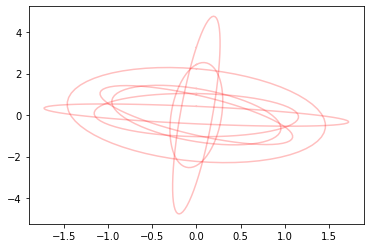

In [10]:
def plot_ellipse(covariance, ax, label_t, alpha_val=0.25, color_def='red', center = [0, 0]):
    if covariance.shape[0] == 2:
        x_el = np.array([np.sin(np.linspace(0, 2*math.pi, num=63)), np.cos(np.linspace(0, 2*math.pi, num=63))])
        C = np.linalg.cholesky(covariance)
        y_el = np.dot(C, x_el)
        ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def)
if(visualize):
    ax = plt.axes()
    for ind, cov in enumerate(sensor_covs):
        plot_ellipse(cov, ax, "Initial " + str(ind + 1))

    plt.show()

In [11]:
class QCQP_solver():
    def __init__(self, P, q, r, z):
        self.ogP = P
        self.ogq = q
        self.ogz = z
        self.ogr = r
        self.P = P
        self.q = q
        self.r = r
        self.z = z
        self.dims = z.size

    
    def perform_cholesky_transform(self, K):
        S = np.linalg.cholesky(K).T
        self.P = inv(S.T) @ self.P @ inv(S)
        self.q = (self.q.T @ inv(S)).T
        self.z = S @ self.z
        self.S = S
    
    def perform_eigen_transform(self):
        e_vals, Q = np.linalg.eig(self.P)
        self.eig = e_vals
        self.P = np.diag(e_vals)
        self.q = Q.T @ self.q
        self.z = Q.T @ self.z
        self.Q = Q
    
    def generate_bounds_for_nu(self):
        bounds = np.zeros((2, 1))
        eig_min = np.min(self.eig)
        eig_max = np.max(self.eig)
        if eig_min>=0:
            if print_value: print("WARNING:  There is no upper limit for nu. It can go to +\infty")
        if eig_max <= 0:
            if print_value: print("WARNING:  nu will have to be negative for I+nu \Lambda to be psd. No limits on it")
        bounds[1]= -1/np.min(self.eig)
        bounds[0] = -1/np.max(self.eig)
        # if print_value: print('bounds before sort',bounds,'and after sort',np.sort(bounds))
        self.bounds = np.sort(bounds)

    def calculate_value(self, nu):
        A = self.eig*np.power(nu*self.q-2*self.z, 2)
        B = 4*np.power(1+nu*self.eig, 2)

        C = (self.q*(nu*self.q-2*self.z))
        D = 2*(1+nu*self.eig)
        # if print_value: print(f'eigs is {self.eig}, q is {self.q}, nu is {nu}, z is {self.z}')
        # if print_value: print(f'A is {A}, B is {B}, C is {C}, D is {D}, r is {self.r}')
        return np.sum(A/B - C/D) + self.r

    def calculate_derivative(self, nu):
        return -np.sum(np.power(2*self.eig*self.z+self.q, 2)/np.power(2*(1+nu*self.eig), 3))

    def get_potential_nus(self):
        return np.linspace(self.bounds[0]+1E-3, self.bounds[1]-1E-3, abs(int((self.bounds[1]-self.bounds[0])*2048)))    


    def binary_search_nu(self):
        b = np.copy(self.bounds)
        for i in range(100):
            nu = (b[0] + b[1])/2
            val = self.calculate_value(nu)
            if val > 0:
                b[0] = nu
            elif val < 0:
                b[1] = nu
            else:
                break
        return nu

    def find_optimal_nu(self):
        nu = self.binary_search_nu()
        if print_value: print("Constraint value in terms of nu: " + str(self.calculate_value(nu)))
        return nu

    def inverse_eigen_transform(self, x):
        self.P = self.Q @ self.P @ self.Q.T
        self.z = self.Q @ self.z
        self.q = self.Q @ self.q
        return self.Q @ x
    
    def inverse_cholseky(self, x):
        self.P = self.S.T @ self.P @ self.S
        self.q = (self.q.T @ self.S).T
        self.z = inv(self.S) @ self.z
        return inv(self.S) @ x

    def calculate_constraint(self, x):
        return x.T @ self.P @ x + self.q.T @ x + self.r


    def calculate_x_c_val(self, nu):
        x_c = -(0.5)*inv(np.identity(self.dims) + nu * np.diag(self.eig)) @ (nu*self.q - 2*self.z)
        if print_value: print("Constraint value in terms of x_c: " + str(self.calculate_constraint(x_c)))
        return x_c

    def calculate_x_c_case1(self, nu):
        x_hat = self.calculate_x_c_val(nu)
        tilde_x_c = self.inverse_eigen_transform(x_hat)
        return self.inverse_cholseky(tilde_x_c)

    def case_2(self, nu):
        return (0.5)*np.linalg.pinv(np.identity(self.dims) + nu*self.P) @ (2*self.z - nu*self.q)

    def calculate_x_case2(self):
        if self.bounds[0] < 0:
            if print_value: print("\nLOWER BOUND NU:")
            x_test_hat = self.case_2(self.bounds[0])
            if print_value: print(x_test_hat.T @ self.P @ x_test_hat + self.q.T @ x_test_hat + self.r)
            if print_value: print("\n")
        if self.bounds[1] > 0:
            if print_value: print("\nLOWER BOUND NU:")
            x_test_hat = self.case_2(self.bounds[1])
            if print_value: print(x_test_hat.T @ self.P @ x_test_hat + self.q.T @ x_test_hat + self.r)
            if print_value: print("\n")


In [12]:
def calculate_K(C_a, C_b, C_c):
    C_ac_inv = inv(C_a) - inv(C_c)
    C_bc_inv = inv(C_b) - inv(C_c)

    K_a = inv(C_a) @ (inv(C_ac_inv) @ inv(C_a) - np.identity(C_a.shape[0]))
    K_b = inv(C_b) @ (inv(C_bc_inv)@ inv(C_b) - np.identity(C_b.shape[0]))
    return K_a, K_b

def calculate_QCQP_Coeff(K_a, K_b, x_a, x_b):
    P = K_a - K_b
    q = -2*(x_a @ K_a - x_b @ K_b)
    r = x_a.T @ K_a @ x_a - x_b.T @ K_b @ x_b
    return P, q, r

def calculate_mahalonobis_difference(x_c, x, K):
    return (x-x_c) @ K @ (x - x_c).T


def qcqp_solver_x_c(x_a, x_b, C_a, C_b, C_c):
    dims = x_a.size
    if print_value: print(dims)
    if dims > 1:
        C_ac_inv = inv(C_a) - inv(C_c)
        C_bc_inv = inv(C_b) - inv(C_c)

        K_a, K_b = calculate_K(C_a, C_b, C_c)
        P, q, r = calculate_QCQP_Coeff(K_a, K_b, x_a, x_b)

        solver = QCQP_solver(P, q, r, x_a)

        solver.perform_cholesky_transform(K_a)
        solver.perform_eigen_transform()
        solver.generate_bounds_for_nu()

        ################CASE 1#############################
        nu = solver.find_optimal_nu()
        x_c = inv(inv(C_ac) + inv(C_bc)) @ (inv(C_ac) @ x_a + inv(C_bc) @ x_b)
        a_diff = calculate_mahalonobis_difference(x_c, x_a, K_a)
        b_diff = calculate_mahalonobis_difference(x_c, x_b, K_b)
        if print_values: print("Mahalonobis difference to A: " + str(a_diff))
        if print_values: print("Mahalonobis difference to B: " + str(b_diff))
        return a_diff, b_diff, x_c
    else:
        K_a, K_b = calculate_K(C_a, C_b, C_c)
        a = (K_a - K_b)
        b = -2*(K_a*x_a - K_b*x_b)
        c = K_a*x_a**2-K_b*x_b**2
        
        x_c_1 = (-b + math.sqrt(b**2-4*a*c))/(2*a)
        x_c_2 = (-b - math.sqrt(b**2-4*a*c))/(2*a)
        
        if np.sign(x_b - x_c_1) != np.sign(x_a - x_c_1):
            x_c = x_c_1
        else:
            x_c = x_c_2
        a_diff = calculate_mahalonobis_difference(x_c, x_a, K_a)
        b_diff = calculate_mahalonobis_difference(x_c, x_b, K_b)
        if print_values: print("Mahalonobis difference to A: " + str(a_diff))
        if print_values: print("Mahalonobis difference to B: " + str(b_diff))
        return a_diff, b_diff, x_c

        


In [13]:
a = random.randint(0, N_agents - 1)
b = random.randint(0, N_agents - 1)
while(b == a):
    b = random.randint(0, N_agents - 1)

if not use_predefined_values:
    x_a = sensor_mus[a]
    x_b = sensor_mus[b]

    C_a = sensor_covs[a]
    C_b = sensor_covs[b]
else:
    x_a, x_b, C_a, C_b = read_in_initial_values(my_space.dim)

print("~~~~~~~~~~~~~~~~~~~Initial Distributions~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(str(x_a) + " | " + str(x_b))

~~~~~~~~~~~~~~~~~~~Initial Distributions~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[72.12688793 75.88634715] | [72.21211198 71.69496266]


In [14]:
def mutual_covariance(cov_a, cov_b):
    D_a, S_a = np.linalg.eigh(cov_a)
    D_a_sqrt = sqrtm(np.diag(D_a))
    D_a_sqrt_inv = inv(D_a_sqrt)
    M = np.dot(np.dot(np.dot(np.dot(D_a_sqrt_inv, inv(S_a)), cov_b), S_a), D_a_sqrt_inv)    # eqn. 10 in Sijs et al.
    D_b, S_b = np.linalg.eigh(M)
    D_gamma = np.diag(np.clip(D_b, a_min=1.0, a_max=None))   # eqn. 11b in Sijs et al.
    return np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(S_a, D_a_sqrt), S_b), D_gamma), inv(S_b)), D_a_sqrt), inv(S_a))  # eqn. 11a in Sijs et al

C_c = mutual_covariance(C_a, C_b) + 1e-1*np.identity(my_space.dim)
C_ac_inv = inv(C_a) - inv(C_c)
C_ac = inv(C_ac_inv)
C_bc_inv = inv(C_b) - inv(C_c)
C_bc = inv(C_bc_inv)

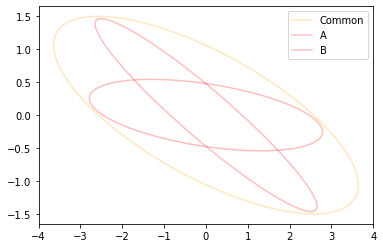

In [15]:
if(visualize):
    plt.cla()
    plt.clf()
    ax = plt.axes()
    plot_ellipse(C_c, ax, "Common", color_def="orange")
    plot_ellipse(C_a, ax, "A")
    plot_ellipse(C_b, ax, "B")
    ax.legend()
    plt.show()

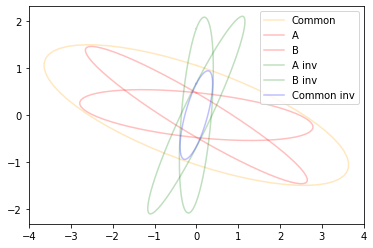

In [16]:
if(visualize):
    ax = plt.axes()
    plot_ellipse(C_c, ax, "Common", color_def="orange")
    plot_ellipse(C_a, ax, "A")
    plot_ellipse(C_b, ax, "B")
    plot_ellipse(inv(C_a), ax, "A inv", color_def="green")
    plot_ellipse(inv(C_b), ax, "B inv", color_def="green")
    plot_ellipse(inv(C_c), ax, "Common inv", color_def="blue")
    ax.legend()
    plt.show()


In [17]:
from scipy.stats import multivariate_normal
def visualize_one_dimensional(x_a, x_b, x_c, C_a, C_b, C_c):
    lb = min(x_a, x_b) - 3*max(C_b, C_a)
    ub = max(x_a, x_b) + 3*max(C_b, C_a)
    x = np.linspace(lb, ub, 1024, endpoint=False)
    ya = multivariate_normal.pdf(x, mean=x_a, cov=C_a)
    yb = multivariate_normal.pdf(x, mean=x_b, cov=C_b)
    yc = multivariate_normal.pdf(x, mean=x_c, cov=C_c)
    plt.cla()
    plt.clf()
    ax = plt.axes()
    ax.plot(x, ya, label="A distribution")
    ax.plot(x, yb, label="B distribution")
    ax.plot(x, yc, label="C distribution")
    ax.legend()
    plt.show()

In [18]:
a_diff, b_diff, x_c = qcqp_solver_x_c(x_a, x_b, C_a, C_b, C_c)
print(x_c)
print(str(x_a) + " | " + str(x_b))
if(my_space.dim == 1):
    visualize_one_dimensional(x_a[0], x_b[0], x_c[0][0], C_a[0][0], C_b[0][0], C_c[0][0])

[79.65640812 71.46383827]
[72.12688793 75.88634715] | [72.21211198 71.69496266]


In [19]:
x_ac = C_ac @ (inv(C_a) @ x_a - inv(C_c) @ x_c)
x_bc = C_bc @ (inv(C_b) @ x_b - inv(C_c) @ x_c)
if(my_space.dim == 1):
    visualize_one_dimensional(x_ac[0], x_bc[0], x_c[0][0], C_a[0][0], C_b[0][0], C_c[0][0])

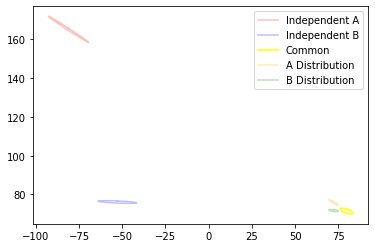

In [20]:
if(visualize):
    plt.cla()
    plt.clf()
    ax = plt.axes()

    plot_ellipse(C_ac, ax, "Independent A", center=x_ac)

    plot_ellipse(C_bc, ax, "Independent B", color_def="blue", center=x_bc)

    plot_ellipse(C_c, ax, "Common", color_def="yellow", center=x_c, alpha_val = 1)

    plot_ellipse(C_a, ax, "A Distribution", color_def="orange" ,center=x_a)

    plot_ellipse(C_b, ax, "B Distribution", color_def = "green", center=x_b)

    ax.legend()
    plt.show()

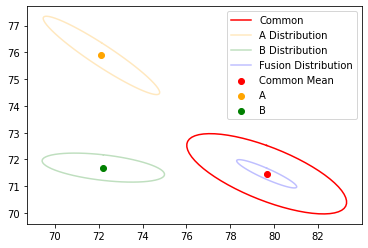

In [21]:
if(visualize):
    C_fus = C_a @ inv(C_c) @ C_b

    plt.cla()
    plt.clf()
    ax = plt.axes()
    if(my_space.dim > 1):
        plt.scatter(x_c[0], x_c[1], color="red", label = "Common Mean")
        plot_ellipse(C_c, ax, "Common", color_def="red", center=x_c, alpha_val = 1)
        plt.scatter(x_a[0], x_a[1], color="orange", label = "A")
        plt.scatter(x_b[0], x_b[1], color="green", label = "B")
        plot_ellipse(C_a, ax, "A Distribution", color_def="orange" ,center=x_a)
        plot_ellipse(C_b, ax, "B Distribution", color_def = "green", center=x_b)
        plot_ellipse(C_fus, ax, "Fusion Distribution", color_def = "blue", center=x_c)
    else:
        plt.scatter(x_c[0], 0, color="red", label = "Common Mean")
        plt.scatter(x_a[0], 0, color="orange", label = "A")
        plt.scatter(x_b[0], 0, color="green", label = "B")

        print(C_b)
        print(C_a)
    ax.legend()
    plt.show()

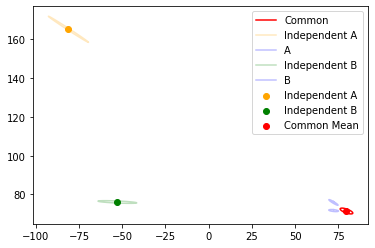

In [22]:
if visualize:
    plt.cla()
    plt.clf()
    ax = plt.axes()

    plt.scatter(x_ac[0], x_ac[1], color="orange", label = "Independent A")
    plt.scatter(x_bc[0], x_bc[1], color="green", label = "Independent B")
    plt.scatter(x_c[0], x_c[1], color="red", label = "Common Mean")
    plot_ellipse(C_c, ax, "Common", color_def="red", center=x_c, alpha_val = 1)
    plot_ellipse(C_ac, ax, "Independent A", center=x_ac, color_def = "orange")
    plot_ellipse(C_a, ax, "A", center = x_a, color_def="blue")
    plot_ellipse(C_bc, ax, "Independent B", center=x_bc , color_def="green")
    plot_ellipse(C_b, ax, "B", center = x_b, color_def="blue")

    ax.legend()
    plt.show()

In [23]:
from scipy.stats import chi2

def get_critical_value(dimensions, alpha):
    return chi2.ppf((1 - alpha), df=dimensions)

cr_05 = get_critical_value(my_space.dim, 0.05)
cr_10 = get_critical_value(my_space.dim, 0.1)

In [24]:
def test_multiplier(outer, m, C_c):
    return C_c - m*outer

def inv(mat):
    return np.linalg.inv(mat)

def normalize(arr):
    return arr/np.linalg.norm(arr)


x_a, x_b, C_a, C_b = read_in_initial_values(my_space.dim, as_tensors=False)
o = normalize(x_a - x_b).reshape((1, 2))
outer = np.identity(2)
C = mutual_covariance(C_a, C_b)

def calculate_distance(x_c, x_ac, C_ac, C_c):
    return (x_ac - x_c).T @ inv(C_ac + C_c) @ (x_ac - x_c)

bounds = np.linspace(0, 1e-1, 1000)
a = []
for n in bounds:
    C_c = test_multiplier(outer, n, C)
    C_ac = inv(inv(C_a) - inv(C_c))
    C_bc = inv(inv(C_b) - inv(C_c))
    x_c = inv(inv(C_ac) + inv(C_bc)) @ (inv(C_ac) @ x_a + inv(C_bc) @ x_b)
    x_ac = C_ac @ (inv(C_a) @ x_a - inv(C_c) @ x_c)
    x_bc = C_bc @ (inv(C_b) @ x_b - inv(C_c) @ x_c)
    a.append(calculate_distance(x_c, x_ac, C_ac, C_c))

plt.cla()
plt.clf()
plt.plot(bounds, a)
plt.show()



LinAlgError: Singular matrix

In [25]:
def get_rotation_matrix(a):
    theta = np.radians(a)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]])

In [26]:
def transform(rotate, angle):
    vec_ab = np.array([(x_a - x_b)/np.linalg.norm(x_a - x_b)])    
    if rotate:
        vec_ab = get_rotation_matrix(angle) @ vec_ab.T
    mat_ab = vec_ab @ vec_ab.T
    multiplier = np.linspace(0, 10, 100)
    C_c = mutual_covariance(C_a, C_b)+ mat_ab
    a_diff, b_diff, x_c = qcqp_solver_x_c(x_a, x_b, C_a, C_b, C_c)
    return a_diff

249


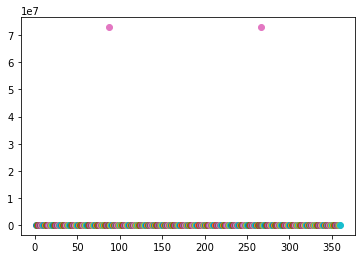

In [27]:
original_value = a_diff
ax = plt.axes()
angles = np.linspace(1, 360, 360)
f_s = []
x_a, x_b, C_a, C_b = read_in_initial_values(my_space.dim, as_tensors=False)
if(my_space.dim == 2):
    for a in angles:
        f = abs(original_value - transform(True, a))
        f_s.append(f)
        ax.scatter(a, f)
print(f_s.index(min(f_s))+1)

In [28]:
def normalize(arr):
    return arr/np.linalg.norm(arr)

def angle_between_vectors(a1, b1):
    a = normalize(a1)
    b = normalize(b1)
    print(np.dot(a, b))
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a) * np.linalg.norm(b)))

def perform_fusion_given_z(z):
    t = normalize(np.copy(z))
    C_c = mutual_covariance(C_a, C_b) + 1e-5*t.T @ t
    print("DEG" + str(np.degrees(angle_between_vectors(x_a-x_b, t))))
    a, b, x_c = qcqp_solver_x_c(x_a, x_b, C_a, C_b, C_c)
    print("A:" + str(a))

In [29]:
import torch

def find_z(d):
    z = torch.from_numpy(d)
    z.requires_grad = True
    C_c_t = torch.from_numpy(C_c)
    C_a_t = torch.from_numpy(C_a)
    x_ct = torch.from_numpy(x_c)
    x_at = torch.from_numpy(x_a)

    C = C_c_t + z.T @ z
    C_act = torch.inverse(torch.inverse(C_a_t) - torch.inverse(C))
    x_act = C_act @ (torch.inverse(C_a_t)@x_at - torch.inverse(C_c_t)@x_ct)

    Z = (x_act-x_ct).T @ torch.inverse(C_act + C) @ (x_act - x_ct)
    out = Z.mean()
    out.backward()
    return z.grad


In [30]:
z = normalize(x_a - x_b)
for i in range(20):
    a = find_z(z)
    z = z - a.numpy()
    perform_fusion_given_z(z)

-1.0
DEG180.0
A:1646257.7224937044
-1.0000000000000002
DEGnan
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044
-1.0
DEG180.0
A:1646257.7224937044


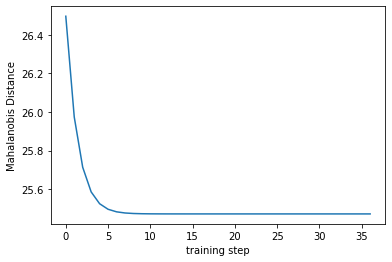

[[-0.23762806  0.97135622]]
12.581745844440668


In [34]:
import torch
import torchgeometry as tgm

def tinv(mat):
    return torch.inverse(mat)

def normalize(arr, numpy_as = False):
    if(numpy_as):
        return arr/np.linalg.norm(arr)    
    return arr/torch.norm(arr)

def get_rotation_matrix(theta):
    dimensions = theta.shape[0] + 1
    t = torch.cat((theta, torch.zeros((4 - dimensions, 1))))
    return tgm.angle_axis_to_rotation_matrix(t.T)[:dimensions, :dimensions, :dimensions][0]
    
all_zs = []    
def update(z, og_Cc, C_a, C_b, x_a, x_b, zs):
    C_c = og_Cc + z.T @ z
    C_ac = torch.inverse(torch.inverse(C_a) - torch.inverse(C_c))
    C_bc = torch.inverse(torch.inverse(C_b) - torch.inverse(C_c))
    x_c = tinv(tinv(C_ac) + tinv(C_bc)) @ (tinv(C_ac) @ x_a + tinv(C_bc) @ x_b)
    x_ac = C_ac @ (torch.inverse(C_a) @ x_a - torch.inverse(C_c) @ x_c)
    x_bc = C_bc @ (torch.inverse(C_b) @ x_b - torch.inverse(C_c) @ x_c)
    Z = (x_ac - x_c).T @ tinv(C_ac + C_c) @ (x_ac - x_c)
    z.retain_grad()
    Z.backward(retain_graph=True)
    zs.append(Z.data)
    return z.grad

x_a, x_b, C_a, C_b = read_in_initial_values(my_space.dim, as_tensors=True)
C_c = torch.tensor(mutual_covariance(C_a, C_b))
z = normalize(x_a - x_b).reshape((1, 2))
z.requires_grad = True
continue_o = True
i = 0
while(True):
    g = 1e-2*update(z, C_c, C_a, C_b, x_a, x_b, all_zs)
    if len(all_zs) > 1 and all_zs[-2] <= all_zs[-1]:
        break
    z = normalize(z - g)

j = [i for i in range(len(all_zs))]

plt.plot(j, all_zs)
plt.xlabel("training step")
plt.ylabel("Mahalanobis Distance")
plt.show()
    
print("=========================")
a = normalize(x_a.numpy() - x_b.numpy(), numpy_as = True)
b = z.detach().numpy()[0]
print(z.detach().numpy())

print(np.degrees(np.arccos(np.dot(a, b))))



In [ ]:
b = z.detach().numpy()
print(b.shape)
outer = b.T @ b


In [ ]:
def test_multiplier(outer, m, C_c):
    return C_c - m*outer

def inv(mat):
    return np.linalg.inv(mat)

def normalize(arr):
    return arr/np.linalg.norm(arr)


x_a, x_b, C_a, C_b = read_in_initial_values(my_space.dim, as_tensors=False)
o = normalize(x_a - x_b).reshape((1, 2))
outer = np.identity(2)
C = mutual_covariance(C_a, C_b)

def calculate_distance(x_c, x_ac, C_ac, C_c):
    return (x_ac - x_c).T @ inv(C_ac + C_c) @ (x_ac - x_c)

bounds = np.linspace(0, 1e-1, 1000)
a = []
for n in bounds:
    C_c = test_multiplier(outer, n, C)
    C_ac = inv(inv(C_a) - inv(C_c))
    C_bc = inv(inv(C_b) - inv(C_c))
    x_c = inv(inv(C_ac) + inv(C_bc)) @ (inv(C_ac) @ x_a + inv(C_bc) @ x_b)
    x_ac = C_ac @ (inv(C_a) @ x_a - inv(C_c) @ x_c)
    x_bc = C_bc @ (inv(C_b) @ x_b - inv(C_c) @ x_c)
    a.append(calculate_distance(x_c, x_ac, C_ac, C_c))

plt.cla()
plt.clf()
plt.plot(bounds, a)
plt.show()

